In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

## 1. Setup Environment

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
#!pip show pytorch-gradcam
#!ls /usr/local/lib/python3.11/dist-packages/

## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

## 3. Data Preparation

# Define transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])


# Set up normalization based on the cifar10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
size = (224, 224)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

## 4. Model Setup

# Load pre-trained models
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify classification heads
# For ViT
vit_model.head = nn.Linear(vit_model.head.in_features, 10)

# multi GPU setup
# vit_model = nn.DataParallel(vit_model)

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
from tqdm import tqdm
from torch.amp import autocast

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []
    lrs = [] 
    best_acc = 0.0

    scaler = torch.amp.GradScaler(device='cuda', enabled=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 記錄當前學習率
        current_lr = scheduler.get_last_lr()[0]
        lrs.append(current_lr)

        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda', enabled=True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        avg_train_loss = running_loss / len(trainloader)
        train_acc = correct / total * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}, LR: {current_lr:.6e}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}")

        # Evaluate
        eval_loss, eval_acc = evaluate_model(model, testloader, criterion)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_acc)

        if eval_acc > best_acc:
            best_acc = eval_acc
            torch.save(model.state_dict(), "./ViT_7e-4/best_ViT_7e-4_model.pth")
            print("🧠 Best model updated.")

    return train_losses, train_accuracies, eval_losses, eval_accuracies, lrs
    
def evaluate_model(model, testloader, criterion):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Eval Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [5]:
# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=7e-4) # 7e-4, 5e-5

# Train models
print("Training Vision Transformer...")
train_losses, train_accuracies, eval_losses, eval_accuracies, lrs = train_model(vit_model, trainloader, testloader, criterion, vit_optimizer, num_epochs=200)

Training Vision Transformer...


Epoch 1: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 1, LR: 7.000000e-04, Train Loss: 2.1476, Train Acc: 22.77


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 1.7814, Accuracy: 32.40%
🧠 Best model updated.


Epoch 2: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 2, LR: 6.999568e-04, Train Loss: 1.6396, Train Acc: 38.50


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 1.4789, Accuracy: 43.88%
🧠 Best model updated.


Epoch 3: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 3, LR: 6.998273e-04, Train Loss: 1.4698, Train Acc: 46.14


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 1.3820, Accuracy: 47.80%
🧠 Best model updated.


Epoch 4: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 4, LR: 6.996115e-04, Train Loss: 1.3667, Train Acc: 50.17


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 1.2689, Accuracy: 53.53%
🧠 Best model updated.


Epoch 5: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 5, LR: 6.993094e-04, Train Loss: 1.2869, Train Acc: 53.38


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 1.2307, Accuracy: 54.49%
🧠 Best model updated.


Epoch 6: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 6, LR: 6.989211e-04, Train Loss: 1.2255, Train Acc: 55.50


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.49it/s]


Eval Loss: 1.1647, Accuracy: 57.66%
🧠 Best model updated.


Epoch 7: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 7, LR: 6.984467e-04, Train Loss: 1.1764, Train Acc: 57.25


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 1.1344, Accuracy: 58.45%
🧠 Best model updated.


Epoch 8: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 8, LR: 6.978863e-04, Train Loss: 1.1251, Train Acc: 59.29


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 1.0654, Accuracy: 60.93%
🧠 Best model updated.


Epoch 9: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s]


Epoch 9, LR: 6.972401e-04, Train Loss: 1.0786, Train Acc: 61.14


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 1.0755, Accuracy: 61.83%
🧠 Best model updated.


Epoch 10: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 10, LR: 6.965083e-04, Train Loss: 1.0383, Train Acc: 62.71


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 1.0986, Accuracy: 60.84%


Epoch 11: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 11, LR: 6.956909e-04, Train Loss: 0.9869, Train Acc: 64.51


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


Eval Loss: 0.9658, Accuracy: 65.13%
🧠 Best model updated.


Epoch 12: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 12, LR: 6.947883e-04, Train Loss: 0.9494, Train Acc: 65.88


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9543, Accuracy: 65.75%
🧠 Best model updated.


Epoch 13: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 13, LR: 6.938005e-04, Train Loss: 0.9013, Train Acc: 67.77


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.9375, Accuracy: 66.05%
🧠 Best model updated.


Epoch 14: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 14, LR: 6.927280e-04, Train Loss: 0.8630, Train Acc: 69.23


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9301, Accuracy: 66.74%
🧠 Best model updated.


Epoch 15: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 15, LR: 6.915709e-04, Train Loss: 0.8312, Train Acc: 70.35


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.8499, Accuracy: 69.47%
🧠 Best model updated.


Epoch 16: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 16, LR: 6.903295e-04, Train Loss: 0.7897, Train Acc: 72.11


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.8480, Accuracy: 69.42%


Epoch 17: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 17, LR: 6.890041e-04, Train Loss: 0.7618, Train Acc: 73.18


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.7833, Accuracy: 72.09%
🧠 Best model updated.


Epoch 18: 100%|██████████| 391/391 [01:58<00:00,  3.30it/s]


Epoch 18, LR: 6.875951e-04, Train Loss: 0.7220, Train Acc: 74.41


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.7506, Accuracy: 73.46%
🧠 Best model updated.


Epoch 19: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s]


Epoch 19, LR: 6.861028e-04, Train Loss: 0.6974, Train Acc: 75.36


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 0.7452, Accuracy: 73.40%


Epoch 20: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 20, LR: 6.845276e-04, Train Loss: 0.6646, Train Acc: 76.41


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.7437, Accuracy: 73.31%


Epoch 21: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 21, LR: 6.828698e-04, Train Loss: 0.6373, Train Acc: 77.42


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 0.7337, Accuracy: 73.92%
🧠 Best model updated.


Epoch 22: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 22, LR: 6.811299e-04, Train Loss: 0.6125, Train Acc: 78.25


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.7380, Accuracy: 74.15%
🧠 Best model updated.


Epoch 23: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 23, LR: 6.793083e-04, Train Loss: 0.5833, Train Acc: 79.32


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6771, Accuracy: 76.77%
🧠 Best model updated.


Epoch 24: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 24, LR: 6.774054e-04, Train Loss: 0.5594, Train Acc: 80.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6507, Accuracy: 77.24%
🧠 Best model updated.


Epoch 25: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 25, LR: 6.754218e-04, Train Loss: 0.5240, Train Acc: 81.57


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.7193, Accuracy: 75.02%


Epoch 26: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 26, LR: 6.733578e-04, Train Loss: 0.5066, Train Acc: 81.92


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.6967, Accuracy: 76.08%


Epoch 27: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 27, LR: 6.712141e-04, Train Loss: 0.4857, Train Acc: 82.82


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6859, Accuracy: 76.40%


Epoch 28: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 28, LR: 6.689911e-04, Train Loss: 0.4618, Train Acc: 83.59


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.6612, Accuracy: 77.41%
🧠 Best model updated.


Epoch 29: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 29, LR: 6.666895e-04, Train Loss: 0.4414, Train Acc: 84.11


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6709, Accuracy: 77.53%
🧠 Best model updated.


Epoch 30: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 30, LR: 6.643097e-04, Train Loss: 0.4152, Train Acc: 84.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6700, Accuracy: 77.69%
🧠 Best model updated.


Epoch 31: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 31, LR: 6.618523e-04, Train Loss: 0.3911, Train Acc: 85.97


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6494, Accuracy: 78.50%
🧠 Best model updated.


Epoch 32: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 32, LR: 6.593180e-04, Train Loss: 0.3729, Train Acc: 86.69


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6250, Accuracy: 79.65%
🧠 Best model updated.


Epoch 33: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 33, LR: 6.567073e-04, Train Loss: 0.3543, Train Acc: 87.32


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.6509, Accuracy: 78.85%


Epoch 34: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 34, LR: 6.540210e-04, Train Loss: 0.3361, Train Acc: 87.88


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6475, Accuracy: 79.27%


Epoch 35: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 35, LR: 6.512597e-04, Train Loss: 0.3158, Train Acc: 88.67


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.6206, Accuracy: 80.24%
🧠 Best model updated.


Epoch 36: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 36, LR: 6.484241e-04, Train Loss: 0.3008, Train Acc: 89.06


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6274, Accuracy: 80.10%


Epoch 37: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 37, LR: 6.455148e-04, Train Loss: 0.2788, Train Acc: 89.96


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.7244, Accuracy: 78.35%


Epoch 38: 100%|██████████| 391/391 [01:58<00:00,  3.30it/s]


Epoch 38, LR: 6.425326e-04, Train Loss: 0.2668, Train Acc: 90.47


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6456, Accuracy: 80.36%
🧠 Best model updated.


Epoch 39: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 39, LR: 6.394782e-04, Train Loss: 0.2451, Train Acc: 91.28


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6699, Accuracy: 80.38%
🧠 Best model updated.


Epoch 40: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 40, LR: 6.363524e-04, Train Loss: 0.2355, Train Acc: 91.74


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.6527, Accuracy: 80.12%


Epoch 41: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 41, LR: 6.331559e-04, Train Loss: 0.2255, Train Acc: 92.01


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6686, Accuracy: 80.43%
🧠 Best model updated.


Epoch 42: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s]


Epoch 42, LR: 6.298896e-04, Train Loss: 0.2082, Train Acc: 92.50


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.6679, Accuracy: 81.02%
🧠 Best model updated.


Epoch 43: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 43, LR: 6.265543e-04, Train Loss: 0.1980, Train Acc: 92.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6977, Accuracy: 79.77%


Epoch 44: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 44, LR: 6.231506e-04, Train Loss: 0.1862, Train Acc: 93.32


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6717, Accuracy: 80.49%


Epoch 45: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 45, LR: 6.196796e-04, Train Loss: 0.1830, Train Acc: 93.59


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.6760, Accuracy: 80.52%


Epoch 46: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 46, LR: 6.161421e-04, Train Loss: 0.1699, Train Acc: 93.91


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.7190, Accuracy: 79.94%


Epoch 47: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 47, LR: 6.125389e-04, Train Loss: 0.1549, Train Acc: 94.52


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.7464, Accuracy: 80.65%


Epoch 48: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 48, LR: 6.088709e-04, Train Loss: 0.1580, Train Acc: 94.29


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.7541, Accuracy: 79.75%


Epoch 49: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 49, LR: 6.051390e-04, Train Loss: 0.1410, Train Acc: 95.01


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.7484, Accuracy: 80.69%


Epoch 50: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 50, LR: 6.013442e-04, Train Loss: 0.1482, Train Acc: 94.71


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.6962, Accuracy: 81.23%
🧠 Best model updated.


Epoch 51: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 51, LR: 5.974874e-04, Train Loss: 0.1270, Train Acc: 95.63


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.7263, Accuracy: 81.19%


Epoch 52: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 52, LR: 5.935695e-04, Train Loss: 0.1190, Train Acc: 95.76


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.7981, Accuracy: 80.31%


Epoch 53: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 53, LR: 5.895915e-04, Train Loss: 0.1219, Train Acc: 95.72


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 0.7734, Accuracy: 80.73%


Epoch 54: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 54, LR: 5.855544e-04, Train Loss: 0.1062, Train Acc: 96.25


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.7730, Accuracy: 80.67%


Epoch 55: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 55, LR: 5.814592e-04, Train Loss: 0.1083, Train Acc: 96.13


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.7951, Accuracy: 79.63%


Epoch 56: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s]


Epoch 56, LR: 5.773068e-04, Train Loss: 0.1058, Train Acc: 96.22


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.8070, Accuracy: 80.59%


Epoch 57: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 57, LR: 5.730984e-04, Train Loss: 0.0995, Train Acc: 96.43


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.7891, Accuracy: 80.73%


Epoch 58: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 58, LR: 5.688349e-04, Train Loss: 0.0998, Train Acc: 96.46


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.8185, Accuracy: 80.08%


Epoch 59: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 59, LR: 5.645175e-04, Train Loss: 0.0962, Train Acc: 96.67


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.8058, Accuracy: 81.04%


Epoch 60: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 60, LR: 5.601471e-04, Train Loss: 0.0876, Train Acc: 96.88


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.8257, Accuracy: 80.74%


Epoch 61: 100%|██████████| 391/391 [01:56<00:00,  3.35it/s]


Epoch 61, LR: 5.557248e-04, Train Loss: 0.0872, Train Acc: 96.90


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.8199, Accuracy: 80.43%


Epoch 62: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 62, LR: 5.512518e-04, Train Loss: 0.0856, Train Acc: 97.05


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.8083, Accuracy: 81.18%


Epoch 63: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 63, LR: 5.467292e-04, Train Loss: 0.0820, Train Acc: 97.04


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.8182, Accuracy: 81.57%
🧠 Best model updated.


Epoch 64: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 64, LR: 5.421580e-04, Train Loss: 0.0736, Train Acc: 97.36


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9269, Accuracy: 80.71%


Epoch 65: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 65, LR: 5.375394e-04, Train Loss: 0.0746, Train Acc: 97.41


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.9192, Accuracy: 80.09%


Epoch 66: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 66, LR: 5.328745e-04, Train Loss: 0.0698, Train Acc: 97.49


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


Eval Loss: 0.8013, Accuracy: 81.31%


Epoch 67: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 67, LR: 5.281645e-04, Train Loss: 0.0711, Train Acc: 97.58


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.8782, Accuracy: 80.48%


Epoch 68: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 68, LR: 5.234105e-04, Train Loss: 0.0640, Train Acc: 97.77


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.8558, Accuracy: 80.74%


Epoch 69: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 69, LR: 5.186138e-04, Train Loss: 0.0638, Train Acc: 97.74


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.8775, Accuracy: 81.06%


Epoch 70: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 70, LR: 5.137754e-04, Train Loss: 0.0625, Train Acc: 97.80


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.9301, Accuracy: 81.49%


Epoch 71: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 71, LR: 5.088967e-04, Train Loss: 0.0641, Train Acc: 97.73


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.8432, Accuracy: 81.61%
🧠 Best model updated.


Epoch 72: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 72, LR: 5.039787e-04, Train Loss: 0.0515, Train Acc: 98.24


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.9019, Accuracy: 81.13%


Epoch 73: 100%|██████████| 391/391 [01:58<00:00,  3.30it/s]


Epoch 73, LR: 4.990228e-04, Train Loss: 0.0621, Train Acc: 97.78


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 0.8717, Accuracy: 81.63%
🧠 Best model updated.


Epoch 74: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 74, LR: 4.940300e-04, Train Loss: 0.0521, Train Acc: 98.17


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.9462, Accuracy: 80.51%


Epoch 75: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 75, LR: 4.890018e-04, Train Loss: 0.0517, Train Acc: 98.15


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9133, Accuracy: 81.52%


Epoch 76: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 76, LR: 4.839392e-04, Train Loss: 0.0523, Train Acc: 98.22


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.8724, Accuracy: 82.18%
🧠 Best model updated.


Epoch 77: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 77, LR: 4.788436e-04, Train Loss: 0.0466, Train Acc: 98.37


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9536, Accuracy: 81.44%


Epoch 78: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 78, LR: 4.737162e-04, Train Loss: 0.0526, Train Acc: 98.17


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.8798, Accuracy: 81.03%


Epoch 79: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 79, LR: 4.685583e-04, Train Loss: 0.0480, Train Acc: 98.35


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.8898, Accuracy: 81.16%


Epoch 80: 100%|██████████| 391/391 [01:58<00:00,  3.30it/s]


Epoch 80, LR: 4.633711e-04, Train Loss: 0.0441, Train Acc: 98.53


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.8864, Accuracy: 81.49%


Epoch 81: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 81, LR: 4.581559e-04, Train Loss: 0.0461, Train Acc: 98.40


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.9152, Accuracy: 81.61%


Epoch 82: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 82, LR: 4.529141e-04, Train Loss: 0.0413, Train Acc: 98.58


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 0.9364, Accuracy: 81.42%


Epoch 83: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 83, LR: 4.476469e-04, Train Loss: 0.0418, Train Acc: 98.52


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.8954, Accuracy: 81.32%


Epoch 84: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 84, LR: 4.423556e-04, Train Loss: 0.0409, Train Acc: 98.61


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9285, Accuracy: 81.28%


Epoch 85: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 85, LR: 4.370415e-04, Train Loss: 0.0378, Train Acc: 98.66


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.34it/s]


Eval Loss: 0.9703, Accuracy: 80.89%


Epoch 86: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 86, LR: 4.317059e-04, Train Loss: 0.0427, Train Acc: 98.49


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.8727, Accuracy: 82.07%


Epoch 87: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 87, LR: 4.263501e-04, Train Loss: 0.0307, Train Acc: 98.94


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 1.0283, Accuracy: 80.88%


Epoch 88: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 88, LR: 4.209756e-04, Train Loss: 0.0389, Train Acc: 98.72


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 0.8852, Accuracy: 81.87%


Epoch 89: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 89, LR: 4.155835e-04, Train Loss: 0.0327, Train Acc: 98.89


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.57it/s]


Eval Loss: 0.9404, Accuracy: 82.16%


Epoch 90: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 90, LR: 4.101752e-04, Train Loss: 0.0324, Train Acc: 98.93


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Eval Loss: 0.9223, Accuracy: 81.40%


Epoch 91: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 91, LR: 4.047521e-04, Train Loss: 0.0300, Train Acc: 99.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9281, Accuracy: 81.54%


Epoch 92: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch 92, LR: 3.993154e-04, Train Loss: 0.0309, Train Acc: 98.91


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 0.9658, Accuracy: 81.94%


Epoch 93: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 93, LR: 3.938666e-04, Train Loss: 0.0319, Train Acc: 98.88


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 1.0718, Accuracy: 81.26%


Epoch 94: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 94, LR: 3.884070e-04, Train Loss: 0.0314, Train Acc: 98.92


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.9995, Accuracy: 81.72%


Epoch 95: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 95, LR: 3.829379e-04, Train Loss: 0.0288, Train Acc: 99.07


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 1.0014, Accuracy: 81.86%


Epoch 96: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 96, LR: 3.774607e-04, Train Loss: 0.0297, Train Acc: 99.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.9229, Accuracy: 82.47%
🧠 Best model updated.


Epoch 97: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 97, LR: 3.719767e-04, Train Loss: 0.0230, Train Acc: 99.25


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 1.0201, Accuracy: 81.70%


Epoch 98: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 98, LR: 3.664873e-04, Train Loss: 0.0243, Train Acc: 99.21


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.9952, Accuracy: 81.45%


Epoch 99: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 99, LR: 3.609938e-04, Train Loss: 0.0265, Train Acc: 99.10


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 1.0216, Accuracy: 81.95%


Epoch 100: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 100, LR: 3.554976e-04, Train Loss: 0.0263, Train Acc: 99.10


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 1.0129, Accuracy: 82.18%


Epoch 101: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 101, LR: 3.500000e-04, Train Loss: 0.0264, Train Acc: 99.10


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 1.0354, Accuracy: 81.98%


Epoch 102: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 102, LR: 3.445024e-04, Train Loss: 0.0203, Train Acc: 99.31


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.9984, Accuracy: 81.80%


Epoch 103: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 103, LR: 3.390062e-04, Train Loss: 0.0216, Train Acc: 99.25


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 0.9819, Accuracy: 81.99%


Epoch 104: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 104, LR: 3.335127e-04, Train Loss: 0.0206, Train Acc: 99.32


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Eval Loss: 1.0417, Accuracy: 82.23%


Epoch 105: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 105, LR: 3.280233e-04, Train Loss: 0.0183, Train Acc: 99.39


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.9976, Accuracy: 81.95%


Epoch 106: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 106, LR: 3.225393e-04, Train Loss: 0.0224, Train Acc: 99.26


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 0.9589, Accuracy: 82.44%


Epoch 107: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 107, LR: 3.170621e-04, Train Loss: 0.0160, Train Acc: 99.49


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


Eval Loss: 1.0511, Accuracy: 82.00%


Epoch 108: 100%|██████████| 391/391 [01:57<00:00,  3.31it/s]


Epoch 108, LR: 3.115930e-04, Train Loss: 0.0222, Train Acc: 99.21


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 1.0386, Accuracy: 81.72%


Epoch 109: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 109, LR: 3.061334e-04, Train Loss: 0.0153, Train Acc: 99.50


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 1.0144, Accuracy: 82.72%
🧠 Best model updated.


Epoch 110: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 110, LR: 3.006846e-04, Train Loss: 0.0153, Train Acc: 99.51


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.51it/s]


Eval Loss: 1.0180, Accuracy: 82.56%


Epoch 111: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 111, LR: 2.952479e-04, Train Loss: 0.0176, Train Acc: 99.37


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 1.0402, Accuracy: 82.04%


Epoch 112: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 112, LR: 2.898248e-04, Train Loss: 0.0164, Train Acc: 99.46


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 1.0484, Accuracy: 82.23%


Epoch 113: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 113, LR: 2.844165e-04, Train Loss: 0.0144, Train Acc: 99.53


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.56it/s]


Eval Loss: 1.0014, Accuracy: 82.68%


Epoch 114: 100%|██████████| 391/391 [01:58<00:00,  3.31it/s]


Epoch 114, LR: 2.790244e-04, Train Loss: 0.0149, Train Acc: 99.48


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Eval Loss: 1.0886, Accuracy: 81.62%


Epoch 115: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 115, LR: 2.736499e-04, Train Loss: 0.0141, Train Acc: 99.54


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.0560, Accuracy: 82.52%


Epoch 116: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 116, LR: 2.682941e-04, Train Loss: 0.0136, Train Acc: 99.54


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.1001, Accuracy: 82.01%


Epoch 117: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 117, LR: 2.629585e-04, Train Loss: 0.0130, Train Acc: 99.54


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.49it/s]


Eval Loss: 1.1024, Accuracy: 82.14%


Epoch 118: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch 118, LR: 2.576444e-04, Train Loss: 0.0123, Train Acc: 99.60


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.1583, Accuracy: 81.66%


Epoch 119: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 119, LR: 2.523531e-04, Train Loss: 0.0114, Train Acc: 99.63


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.0919, Accuracy: 82.54%


Epoch 120: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 120, LR: 2.470859e-04, Train Loss: 0.0106, Train Acc: 99.65


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.0977, Accuracy: 82.55%


Epoch 121: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch 121, LR: 2.418441e-04, Train Loss: 0.0109, Train Acc: 99.63


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.1050, Accuracy: 82.09%


Epoch 122: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 122, LR: 2.366289e-04, Train Loss: 0.0114, Train Acc: 99.64


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.0531, Accuracy: 82.43%


Epoch 123: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 123, LR: 2.314417e-04, Train Loss: 0.0083, Train Acc: 99.71


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.1080, Accuracy: 82.29%


Epoch 124: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 124, LR: 2.262838e-04, Train Loss: 0.0119, Train Acc: 99.58


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.1120, Accuracy: 81.62%


Epoch 125: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 125, LR: 2.211564e-04, Train Loss: 0.0111, Train Acc: 99.66


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Eval Loss: 1.0831, Accuracy: 82.22%


Epoch 126: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 126, LR: 2.160608e-04, Train Loss: 0.0058, Train Acc: 99.78


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.0922, Accuracy: 82.29%


Epoch 127: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 127, LR: 2.109982e-04, Train Loss: 0.0084, Train Acc: 99.71


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.1489, Accuracy: 81.94%


Epoch 128: 100%|██████████| 391/391 [01:59<00:00,  3.27it/s]


Epoch 128, LR: 2.059700e-04, Train Loss: 0.0084, Train Acc: 99.70


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.0865, Accuracy: 82.78%
🧠 Best model updated.


Epoch 129: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 129, LR: 2.009772e-04, Train Loss: 0.0051, Train Acc: 99.84


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1299, Accuracy: 82.28%


Epoch 130: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


Epoch 130, LR: 1.960213e-04, Train Loss: 0.0064, Train Acc: 99.78


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1751, Accuracy: 82.44%


Epoch 131: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 131, LR: 1.911033e-04, Train Loss: 0.0080, Train Acc: 99.75


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1239, Accuracy: 82.67%


Epoch 132: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 132, LR: 1.862246e-04, Train Loss: 0.0062, Train Acc: 99.76


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1226, Accuracy: 82.63%


Epoch 133: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 133, LR: 1.813862e-04, Train Loss: 0.0048, Train Acc: 99.82


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1561, Accuracy: 82.65%


Epoch 134: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 134, LR: 1.765895e-04, Train Loss: 0.0067, Train Acc: 99.78


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1139, Accuracy: 82.96%
🧠 Best model updated.


Epoch 135: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 135, LR: 1.718355e-04, Train Loss: 0.0051, Train Acc: 99.82


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1818, Accuracy: 82.07%


Epoch 136: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 136, LR: 1.671255e-04, Train Loss: 0.0046, Train Acc: 99.86


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.2048, Accuracy: 82.50%


Epoch 137: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 137, LR: 1.624606e-04, Train Loss: 0.0048, Train Acc: 99.82


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.3156, Accuracy: 82.13%


Epoch 138: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 138, LR: 1.578420e-04, Train Loss: 0.0054, Train Acc: 99.82


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.1744, Accuracy: 82.51%


Epoch 139: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch 139, LR: 1.532708e-04, Train Loss: 0.0047, Train Acc: 99.86


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.41it/s]


Eval Loss: 1.2191, Accuracy: 82.44%


Epoch 140: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 140, LR: 1.487482e-04, Train Loss: 0.0037, Train Acc: 99.88


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.2173, Accuracy: 82.51%


Epoch 141: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 141, LR: 1.442752e-04, Train Loss: 0.0035, Train Acc: 99.88


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.2037, Accuracy: 82.65%


Epoch 142: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch 142, LR: 1.398529e-04, Train Loss: 0.0052, Train Acc: 99.82


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.41it/s]


Eval Loss: 1.1657, Accuracy: 82.59%


Epoch 143: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 143, LR: 1.354825e-04, Train Loss: 0.0026, Train Acc: 99.91


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.41it/s]


Eval Loss: 1.2313, Accuracy: 82.67%


Epoch 144: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 144, LR: 1.311651e-04, Train Loss: 0.0035, Train Acc: 99.87


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.2209, Accuracy: 82.66%


Epoch 145: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 145, LR: 1.269016e-04, Train Loss: 0.0028, Train Acc: 99.90


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.2152, Accuracy: 82.98%
🧠 Best model updated.


Epoch 146: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


Epoch 146, LR: 1.226932e-04, Train Loss: 0.0034, Train Acc: 99.88


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.2690, Accuracy: 82.10%


Epoch 147: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


Epoch 147, LR: 1.185408e-04, Train Loss: 0.0026, Train Acc: 99.91


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2391, Accuracy: 83.07%
🧠 Best model updated.


Epoch 148: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 148, LR: 1.144456e-04, Train Loss: 0.0030, Train Acc: 99.89


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2054, Accuracy: 82.65%


Epoch 149: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


Epoch 149, LR: 1.104085e-04, Train Loss: 0.0021, Train Acc: 99.93


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.1748, Accuracy: 83.06%


Epoch 150: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 150, LR: 1.064305e-04, Train Loss: 0.0015, Train Acc: 99.95


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.2272, Accuracy: 82.97%


Epoch 151: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch 151, LR: 1.025126e-04, Train Loss: 0.0021, Train Acc: 99.93


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.2281, Accuracy: 83.11%
🧠 Best model updated.


Epoch 152: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 152, LR: 9.865580e-05, Train Loss: 0.0017, Train Acc: 99.94


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2567, Accuracy: 82.94%


Epoch 153: 100%|██████████| 391/391 [02:02<00:00,  3.20it/s]


Epoch 153, LR: 9.486098e-05, Train Loss: 0.0022, Train Acc: 99.92


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Eval Loss: 1.3007, Accuracy: 82.54%


Epoch 154: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


Epoch 154, LR: 9.112912e-05, Train Loss: 0.0028, Train Acc: 99.90


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2969, Accuracy: 83.18%
🧠 Best model updated.


Epoch 155: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 155, LR: 8.746113e-05, Train Loss: 0.0014, Train Acc: 99.96


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2822, Accuracy: 83.03%


Epoch 156: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 156, LR: 8.385791e-05, Train Loss: 0.0018, Train Acc: 99.94


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2312, Accuracy: 83.03%


Epoch 157: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 157, LR: 8.032037e-05, Train Loss: 0.0012, Train Acc: 99.97


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2560, Accuracy: 83.31%
🧠 Best model updated.


Epoch 158: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s]


Epoch 158, LR: 7.684936e-05, Train Loss: 0.0004, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3074, Accuracy: 83.35%
🧠 Best model updated.


Epoch 159: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 159, LR: 7.344575e-05, Train Loss: 0.0007, Train Acc: 99.97


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.3431, Accuracy: 82.74%


Epoch 160: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 160, LR: 7.011037e-05, Train Loss: 0.0021, Train Acc: 99.93


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2246, Accuracy: 83.50%
🧠 Best model updated.


Epoch 161: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 161, LR: 6.684405e-05, Train Loss: 0.0009, Train Acc: 99.98


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


Eval Loss: 1.2754, Accuracy: 83.36%


Epoch 162: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 162, LR: 6.364760e-05, Train Loss: 0.0007, Train Acc: 99.98


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


Eval Loss: 1.2894, Accuracy: 83.20%


Epoch 163: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


Epoch 163, LR: 6.052180e-05, Train Loss: 0.0007, Train Acc: 99.98


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


Eval Loss: 1.3021, Accuracy: 82.90%


Epoch 164: 100%|██████████| 391/391 [01:59<00:00,  3.28it/s]


Epoch 164, LR: 5.746742e-05, Train Loss: 0.0006, Train Acc: 99.98


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.49it/s]


Eval Loss: 1.2863, Accuracy: 83.38%


Epoch 165: 100%|██████████| 391/391 [01:58<00:00,  3.29it/s]


Epoch 165, LR: 5.448523e-05, Train Loss: 0.0011, Train Acc: 99.96


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.49it/s]


Eval Loss: 1.3181, Accuracy: 82.92%


Epoch 166: 100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


Epoch 166, LR: 5.157594e-05, Train Loss: 0.0008, Train Acc: 99.98


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.50it/s]


Eval Loss: 1.2737, Accuracy: 83.50%


Epoch 167: 100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


Epoch 167, LR: 4.874029e-05, Train Loss: 0.0005, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.2882, Accuracy: 83.19%


Epoch 168: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 168, LR: 4.597897e-05, Train Loss: 0.0003, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.2982, Accuracy: 83.44%


Epoch 169: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 169, LR: 4.329266e-05, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3234, Accuracy: 83.67%
🧠 Best model updated.


Epoch 170: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 170, LR: 4.068203e-05, Train Loss: 0.0006, Train Acc: 99.98


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3035, Accuracy: 83.59%


Epoch 171: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch 171, LR: 3.814772e-05, Train Loss: 0.0005, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3069, Accuracy: 83.42%


Epoch 172: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


Epoch 172, LR: 3.569035e-05, Train Loss: 0.0004, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.48it/s]


Eval Loss: 1.3225, Accuracy: 83.82%
🧠 Best model updated.


Epoch 173: 100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


Epoch 173, LR: 3.331053e-05, Train Loss: 0.0002, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Eval Loss: 1.3388, Accuracy: 83.69%


Epoch 174: 100%|██████████| 391/391 [01:59<00:00,  3.26it/s]


Epoch 174, LR: 3.100885e-05, Train Loss: 0.0003, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Eval Loss: 1.3403, Accuracy: 83.61%


Epoch 175: 100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


Epoch 175, LR: 2.878588e-05, Train Loss: 0.0002, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.47it/s]


Eval Loss: 1.3374, Accuracy: 83.80%


Epoch 176: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 176, LR: 2.664216e-05, Train Loss: 0.0002, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3281, Accuracy: 83.77%


Epoch 177: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 177, LR: 2.457823e-05, Train Loss: 0.0002, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3550, Accuracy: 83.75%


Epoch 178: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 178, LR: 2.259459e-05, Train Loss: 0.0002, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3515, Accuracy: 83.52%


Epoch 179: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 179, LR: 2.069173e-05, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.3466, Accuracy: 83.66%


Epoch 180: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 180, LR: 1.887012e-05, Train Loss: 0.0002, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3397, Accuracy: 83.55%


Epoch 181: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 181, LR: 1.713022e-05, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3459, Accuracy: 83.63%


Epoch 182: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 182, LR: 1.547244e-05, Train Loss: 0.0002, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3512, Accuracy: 83.51%


Epoch 183: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 183, LR: 1.389721e-05, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3459, Accuracy: 83.70%


Epoch 184: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 184, LR: 1.240490e-05, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3555, Accuracy: 83.59%


Epoch 185: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 185, LR: 1.099589e-05, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.3560, Accuracy: 83.45%


Epoch 186: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 186, LR: 9.670528e-06, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3581, Accuracy: 83.78%


Epoch 187: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch 187, LR: 8.429133e-06, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3487, Accuracy: 83.84%
🧠 Best model updated.


Epoch 188: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s]


Epoch 188, LR: 7.272016e-06, Train Loss: 0.0002, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3552, Accuracy: 83.74%


Epoch 189: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 189, LR: 6.199462e-06, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3621, Accuracy: 83.59%


Epoch 190: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


Epoch 190, LR: 5.211736e-06, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3589, Accuracy: 83.64%


Epoch 191: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch 191, LR: 4.309081e-06, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3619, Accuracy: 83.65%


Epoch 192: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 192, LR: 3.491720e-06, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3581, Accuracy: 83.63%


Epoch 193: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch 193, LR: 2.759855e-06, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Eval Loss: 1.3622, Accuracy: 83.64%


Epoch 194: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch 194, LR: 2.113666e-06, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.3640, Accuracy: 83.58%


Epoch 195: 100%|██████████| 391/391 [02:00<00:00,  3.25it/s]


Epoch 195, LR: 1.553312e-06, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.3649, Accuracy: 83.60%


Epoch 196: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 196, LR: 1.078933e-06, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3652, Accuracy: 83.54%


Epoch 197: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 197, LR: 6.906451e-07, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 1.3648, Accuracy: 83.58%


Epoch 198: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 198, LR: 3.885438e-07, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]


Eval Loss: 1.3649, Accuracy: 83.58%


Epoch 199: 100%|██████████| 391/391 [02:01<00:00,  3.23it/s]


Epoch 199, LR: 1.727039e-07, Train Loss: 0.0000, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:23<00:00,  3.40it/s]


Eval Loss: 1.3651, Accuracy: 83.58%


Epoch 200: 100%|██████████| 391/391 [02:01<00:00,  3.22it/s]


Epoch 200, LR: 4.317863e-08, Train Loss: 0.0001, Train Acc: 100.00


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.44it/s]

Eval Loss: 1.3652, Accuracy: 83.58%


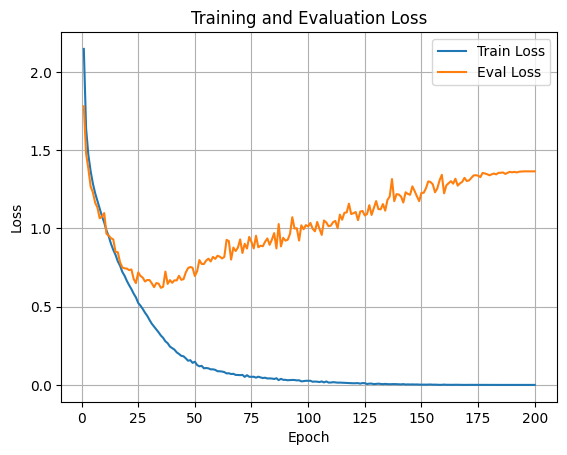

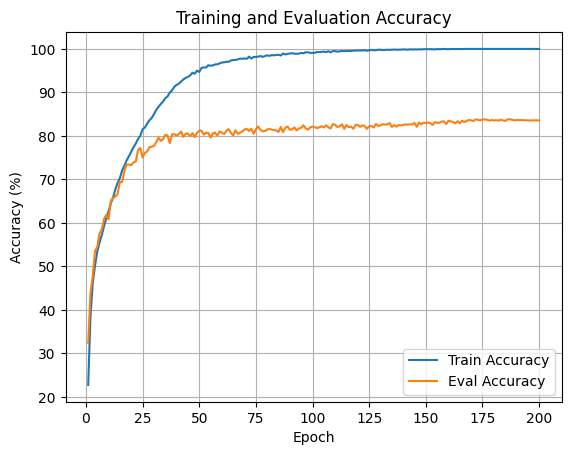

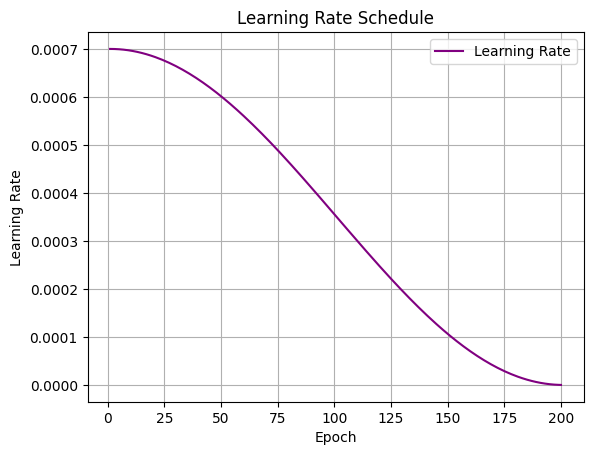

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.savefig("./ViT_7e-4/loss_curve.png")

plt.figure()
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, eval_accuracies, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Evaluation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("./ViT_7e-4/accuracy_curve.png")

plt.figure()
plt.plot(epochs, lrs, label='Learning Rate', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.savefig("./ViT_7e-4/lr_schedule.png")

📦 Total Parameters: 85.81M
⚙️ FLOPs: 16.86 GFLOPs
⏱️ Avg Inference Time: 10.68 ms/image
📊 Max GPU Memory Usage: 2698.10 MB


Testing:  59%|█████▉    | 47/79 [00:15<00:10,  3.06it/s]

Testing: 100%|██████████| 79/79 [00:25<00:00,  3.10it/s]


✅ Accuracy: 0.8384
❌ Top-1 Error Rate: 0.1616
📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.84      0.85      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.82      0.78      0.80      1000
         cat       0.71      0.70      0.70      1000
        deer       0.82      0.81      0.82      1000
         dog       0.77      0.78      0.77      1000
        frog       0.84      0.88      0.86      1000
       horse       0.88      0.87      0.87      1000
        ship       0.89      0.91      0.90      1000
       truck       0.88      0.90      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



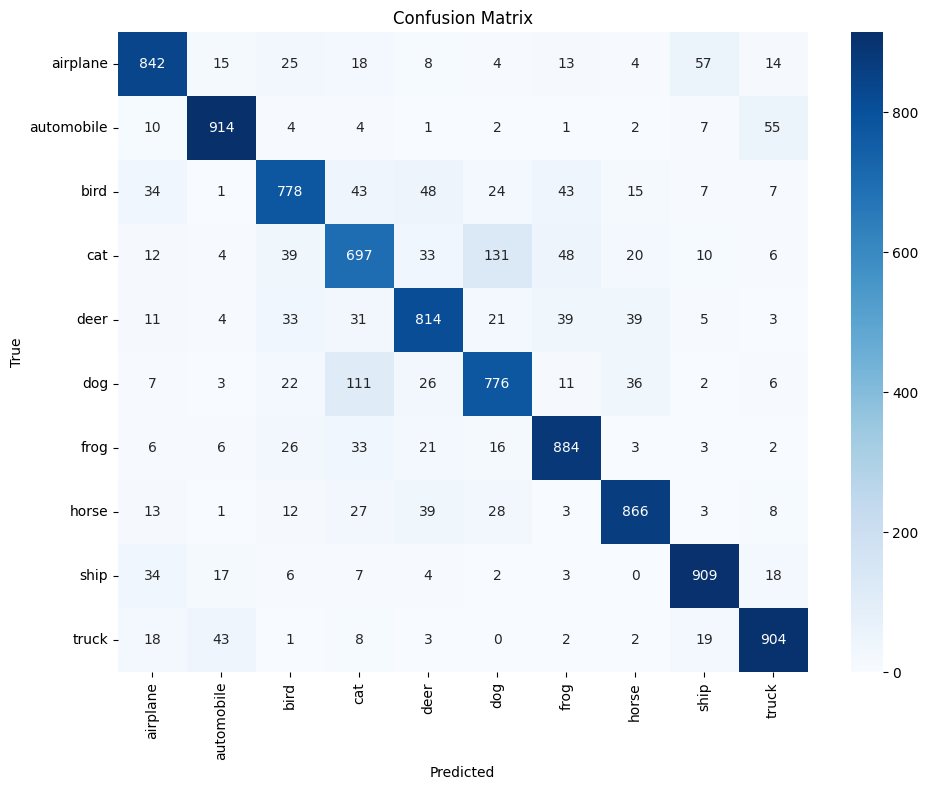

In [7]:
from timm import create_model
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from thop import profile
import time

# Load model
vit_best_model = create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
vit_best_model.load_state_dict(torch.load('./ViT_7e-4/best_ViT_7e-4_model.pth'))
vit_best_model.to(device)
vit_best_model.eval()

# Measure Params (M)
total_params = sum(p.numel() for p in vit_best_model.parameters() if p.requires_grad)
print(f"📦 Total Parameters: {total_params/1e6:.2f}M")

# Measure FLOPs
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_best_model, inputs=(dummy_input,), verbose=False)
print(f"⚙️ FLOPs: {flops / 1e9:.2f} GFLOPs")

# Measure Inference Time
n_test_samples = 100
n_measured = 0
total_time = 0.0

with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        if n_measured >= n_test_samples:
            break
        for img in images:
            if n_measured >= n_test_samples:
                break
            img = img.unsqueeze(0)
            start = time.time()
            _ = vit_best_model(img)
            total_time += time.time() - start
            n_measured += 1

avg_infer_time = total_time / n_measured * 1000  # ms
print(f"⏱️ Avg Inference Time: {avg_infer_time:.2f} ms/image")

# Measure Max GPU Memory Usage
torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        _ = vit_best_model(images)
        break  # Just 1 batch for GPU usage test
max_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
print(f"📊 Max GPU Memory Usage: {max_memory:.2f} MB")

# Inference for accuracy
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing"):
        images = images.cuda()
        labels = labels.cuda()
        outputs = vit_best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
top1_error = 1 - acc

print(f"✅ Accuracy: {acc:.4f}")
print(f"❌ Top-1 Error Rate: {top1_error:.4f}")

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=testset.classes))

cfm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cfm, annot=True, fmt="d", cmap='Blues',
            xticklabels=testset.classes,
            yticklabels=testset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("./ViT_7e-4/confusion_matrix.png")
plt.show()

    (11): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
      (drop_path2): Identity()
    )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (fc_norm): Identity()
  (head_drop): Dropout(p=0.0, inplace=False)
  (head): Linear(in_features=768, out_features=10, bias=True)


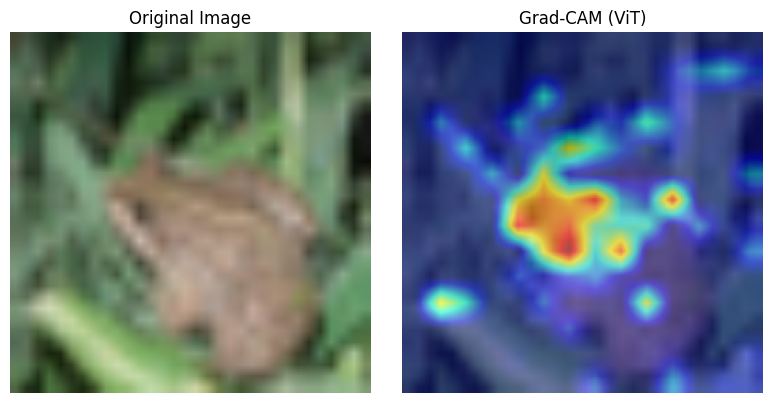

Predicted class: frog
Confidence: 100.00%


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import timm

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

def unnormalize_img(img_tensor):
    """Unnormalize the image tensor to [0,1] range for visualization"""
    # Only take the first image if we got a batch
    if len(img_tensor.shape) == 4:
        img_tensor = img_tensor[0]
    
    # Convert to numpy array on CPU
    img = img_tensor.cpu().numpy()
    
    # Unnormalize: multiply by std and add mean
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    
    # Clamp values to [0,1] range
    img = np.clip(img, 0, 1)
    
    # Convert from [C,H,W] to [H,W,C] for plotting
    img = img.transpose(1, 2, 0)
    
    return img.astype(np.float32)

def vit_reshape_transform(tensor):
    tensor = tensor[:, 1:, :]
    B, N, C = tensor.shape
    H = W = int(N ** 0.5)  # = 14 if N=196
    return tensor.permute(0, 2, 1).reshape(B, C, H, W)

selected_idx = 4
images, labels = next(iter(testloader))
single_img = images[selected_idx:selected_idx+1].to(device)

# ---------- Grad-CAM ----------
# target layer for ViT
target_layer = vit_model.blocks[-1].norm1

cam = GradCAM(model=vit_model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)
grayscale_cam = cam(input_tensor=single_img, targets=None)[0]

original_img = unnormalize_img(single_img) 
cam_img = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_img)
plt.title("Grad-CAM (ViT)")
plt.axis('off')

plt.savefig("./ViT_7e-4/gradcam_vit.png")

plt.tight_layout()
plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    outputs = vit_model(single_img)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
    top_prob, top_class = torch.max(probabilities, 0)
    print(f"Predicted class: {classes[top_class]}")
    print(f"Confidence: {top_prob.item()*100:.2f}%")


Random indices: [34, 16, 65, 30, 126]


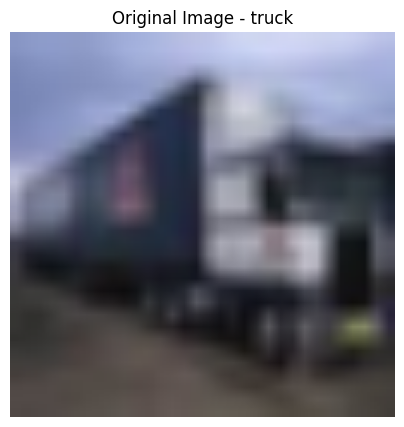

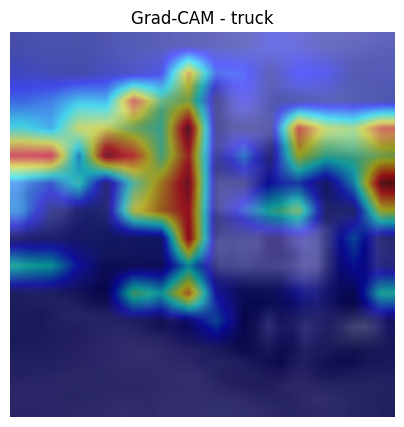

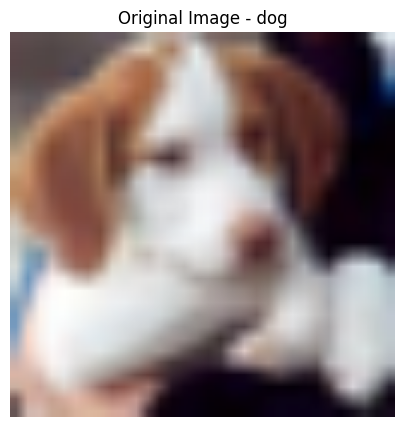

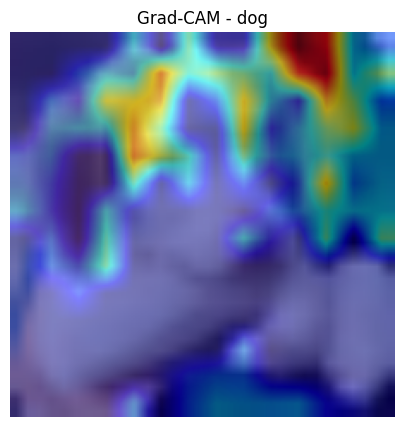

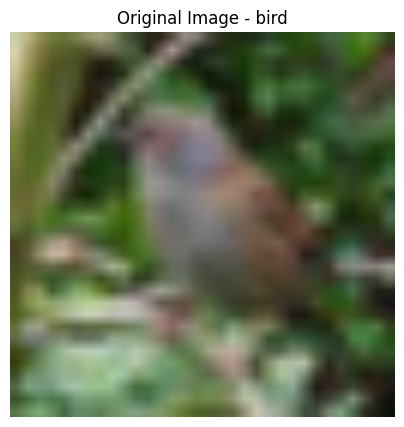

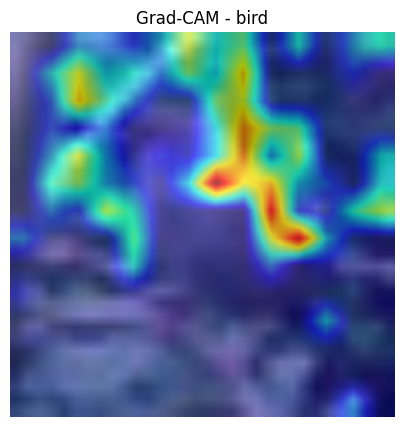

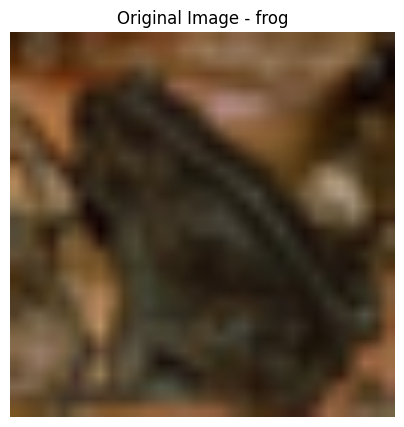

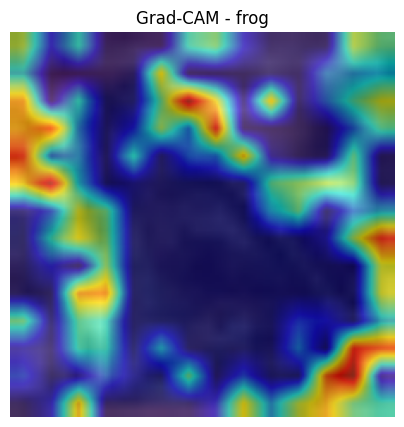

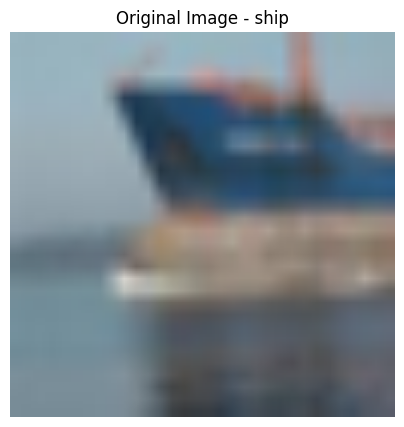

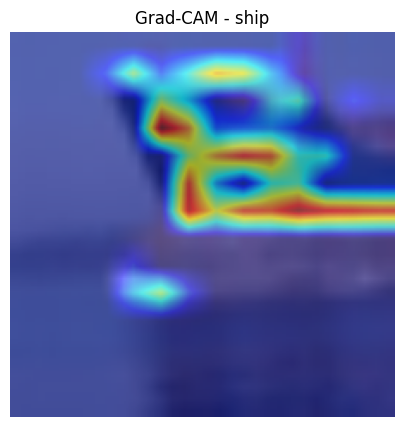

all image have been saved to ./ViT_7e-4/random_images
Already saved:
  - bird_gradcam_65.png
  - bird_original_65.png
  - dog_gradcam_16.png
  - dog_original_16.png
  - frog_gradcam_30.png
  - frog_original_30.png
  - ship_gradcam_126.png
  - ship_original_126.png
  - truck_gradcam_34.png
  - truck_original_34.png


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

output_dir = "./ViT_7e-4/random_images"
os.makedirs(output_dir, exist_ok=True)


images, labels = next(iter(testloader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

seed = 1
random.seed(seed)
total_images = len(images)
random_indices = random.sample(range(total_images), 5)
print(f"Random indices: {random_indices}")

target_layer = vit_model.blocks[-1].norm1
cam = GradCAM(model=vit_model, 
              target_layers=[target_layer], 
              reshape_transform=vit_reshape_transform)

for idx in random_indices:
    single_img = images[idx:idx+1].to(device)
    img_class = classes[labels[idx]]

    grayscale_cam = cam(input_tensor=single_img, targets=None)[0]
    original_img = unnormalize_img(single_img)
    
    cam_img = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(original_img)
    plt.title(f"Original Image - {img_class}")
    plt.axis('off')
    plt.savefig(f"{output_dir}/{img_class}_original_{idx}.png", bbox_inches='tight')
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM - {img_class}")
    plt.axis('off')
    plt.savefig(f"{output_dir}/{img_class}_gradcam_{idx}.png", bbox_inches='tight')
    plt.show()

print(f"all image have been saved to {output_dir}")

print("Already saved:")
for file in sorted(os.listdir(output_dir)):
    print(f"  - {file}")